# Required modules

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random

from types import MethodType

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utilities.data_downloader import train_val_test_downloader, choose_one_column
from utilities.plots import visualize_latent

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

In [5]:
random.seed(42)
np.random.seed(42)

# Analysis Pipeline

In [6]:
def roc_auc_scoring(estimator, X, y)->float:
    yscore = estimator.score_samples(X)
    ytrue = y
    return roc_auc_score(ytrue, yscore)

In [7]:
def make_pipe():
    """
    Makes GridSearchCV pipeline
    """
    return Pipeline(
        [('imputer', SimpleImputer(
            missing_values=np.nan, strategy='median')),
         ('scaler', RobustScaler()),
         ('model', GridSearchCV(
             Pipeline([
                 ('KernelPCA', KernelPCA(random_state=42)),
                 ('KDE', KernelDensity(kernel='gaussian', bandwidth='silverman'))
             ]),
             param_grid={
                 'KernelPCA__n_components': (2, 3),
                 'KernelPCA__kernel': ('linear', 'rbf', 'poly', 'cosine'),
                 'KernelPCA__degree': (2, 3, 4),
                 'KernelPCA__gamma': (0.1, 0.3, 1.0)},
             scoring=roc_auc_scoring, cv=2),
         ),
        ]
    )

In [8]:
def transform_dataset(pipe:Pipeline,
                      train:pd.DataFrame,
                      val:pd.DataFrame,
                      test:pd.DataFrame,
                      labels:pd.DataFrame)->pd.DataFrame:
    """
    Creates a joint dataframe of transformed features.
    """
    train_df, val_df, test_df = [
        pd.DataFrame(data=pipe.transform(df), index=df.index).rename(
        columns=lambda col: f'feature_{col}') for df in (train, val, test)
    ]
    train_df['sample'] = 'train'
    val_df['sample'] = 'val'
    test_df['sample'] = 'test'
    df = pd.concat((train_df, val_df, test_df), axis=0, ignore_index=False)
    df = pd.concat((df, labels), axis=1, ignore_index=False)
    return df

# Extracted Features Analysis

In [9]:
train, val, test, labels = train_val_test_downloader('features')
ytrain = labels.loc[train.index, 'FlaresFlag']

Datasets downloaded
 - train  : 810 entries
 - val    : 174 entries
 - test   : 174 entries
 - labels : 1158 entries


In [10]:
pipe = make_pipe()
pipe.fit(train, ytrain)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('model',
                 GridSearchCV(cv=2,
                              estimator=Pipeline(steps=[('KernelPCA',
                                                         KernelPCA(random_state=42)),
                                                        ('KDE',
                                                         KernelDensity(bandwidth='silverman'))]),
                              param_grid={'KernelPCA__degree': (2, 3, 4),
                                          'KernelPCA__gamma': (0.1, 0.3, 1.0),
                                          'KernelPCA__kernel': ('linear', 'rbf',
                                                                'poly',
                                                                'cosine'),
                                          'KernelPCA__n_components': (2, 3)},
                              scoring=<function roc_auc_scoring at 0x1573de480>))])

In [11]:
def transform(self, dataframe:pd.DataFrame):
    return self._final_estimator.best_estimator_[0].transform(
        self[1].transform(
            self[0].transform(dataframe)
        )
    )
pipe.transform = MethodType(transform, pipe)

In [12]:
df = transform_dataset(pipe, train, val, test, labels)

In [13]:
if not os.path.isdir('./Figures'):
    os.mkdir('./Figures')

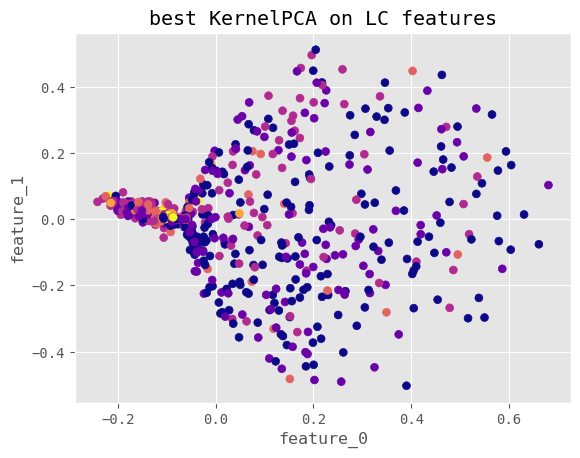

In [14]:
visualize_latent(df, title='best KernelPCA on LC features',
                 savedir='./Figures', show=True)

In [15]:
pipe._final_estimator.best_score_

0.6437830399211977

In [16]:
pipe._final_estimator.best_params_

{'KernelPCA__degree': 2,
 'KernelPCA__gamma': 0.3,
 'KernelPCA__kernel': 'rbf',
 'KernelPCA__n_components': 2}

# Rebinned Lightcurves Analysis

In [ ]:
train, val, test = tuple(
    map(lambda df: choose_one_column(df, 'lgRate'),
    train_val_test_downloader('interp'))
)